c:\Users\lopez\Anaconda3\envs\test_install_cuda_with_pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\lopez\Anaconda3\envs\test_install_cuda_with_pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\lopez\Anaconda3\envs\test_install_cuda_with_pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv_layer:   0 <class 'int'>
FTE:          [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]
conv in FTE True



features.0
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[64, 224, 224, 43]

1/5  Model loading...
torch.Size([14, 43])
conv_layer:   0 <class 'int'>
FTE:          [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]
conv in FTE True



features.0
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
[64, 224, 224, 43]
      Model loaded and tested...


2/5   Loading Paolo's model
mixed4a
CatLayer()
      Loaded


3/5   Loading activations...
      Loaded


4/5   Getting validation activations...
      Done


5/5   Plotting...
      Done



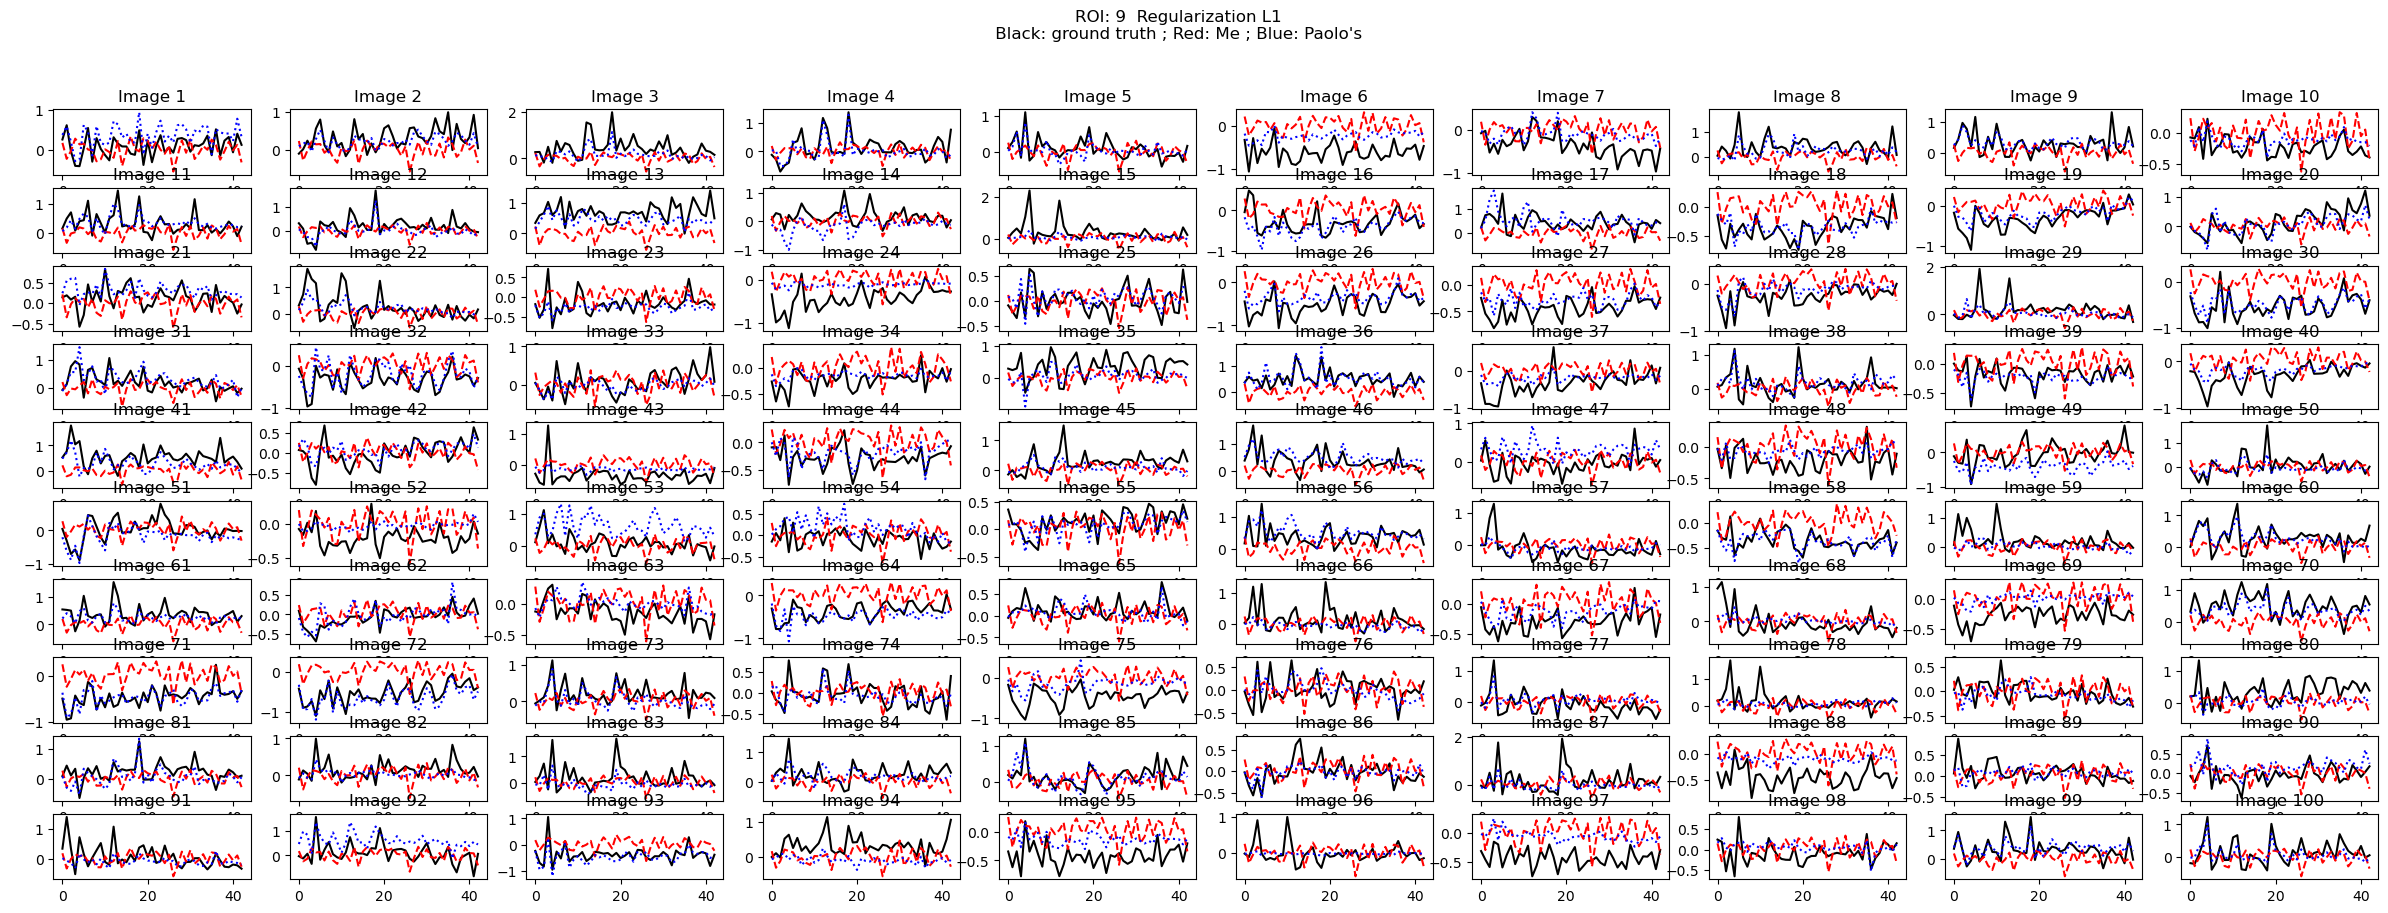

In [1]:
roi_name = '9'


import torch
from lucent.modelzoo import vgg19, util
from cadena_model import VggModel

vgg_pretrained = vgg19(pretrained = True)

gpu_to_use = 0
n_neurons = 43
layer = 0


GPU = torch.cuda.is_available()
net = VggModel(pretrained_model=vgg_pretrained, conv_layer=layer, num_neurons=n_neurons, device = torch.device("cuda:"+str(gpu_to_use) if GPU else "cpu"))
net.cuda()

print('\n1/5  Model loading...')
net.load_state_dict(torch.load('E:/Jose/models\\model_9_0_1668242975_epoch_2_loss_0.21454372439322444.pt', map_location=torch.device("cuda:"+str(gpu_to_use) if GPU else "cpu")))
print(net(torch.rand([14, 3, 224, 224]).cuda()).shape)

# Untrained network, apparently need to have the line defining the pretrained network right before it or it doesnt work
vgg_pretrained = vgg19(pretrained = True)
net_untrained = VggModel(pretrained_model=vgg_pretrained, conv_layer=layer, num_neurons=n_neurons, device = torch.device("cuda:"+str(gpu_to_use) if GPU else "cpu"))
net_untrained.cuda()

print('      Model loaded and tested...\n')



###############   2. Loading paolo model

print('\n2/5   Loading Paolo\'s model')
from neural_model import Model
from lucent.modelzoo import inceptionv1, util, inceptionv1_avgPool
import pickle
import numpy as np

def load_trained_model(roi_name,layer=False):
    if not layer:
        data_filename = 'E:/Jose/snapshots/grid_search_array'+ roi_name +'.pkl'
        f = open(data_filename,"rb")
        cc = pickle.load(f)
        val_corrs = cc['val_corrs']
        params = cc['params']
        val_corrs = np.array(val_corrs)
        layer = params[np.where(val_corrs==val_corrs.max())[0][0].astype('int')][0]
    data_filename      = 'E:/Jose/Data/data_THINGS_array'+ roi_name +'_v1.pkl'
    #data_filename = '/media/stijn/2bb74e85-3681-4561-88b7-abd98482de61/paolo/Data/data_THINGS_array'+ roi_name +'_v1.pkl'
    f = open(data_filename,"rb")
    cc = pickle.load(f)
    val_data = cc['val_data']
    del cc
    
    n_neurons = val_data.shape[1]

    pretrained_model = inceptionv1(pretrained=True)
    roi_model = Model(pretrained_model,layer,n_neurons,device='cpu')
    snapshot_path = f'E:/Jose/snapshots/array'+ roi_name +'_neural_model.pt'
    roi_model.load_state_dict(torch.load(snapshot_path,map_location=torch.device('cpu')))
    return roi_model,n_neurons


model_paolo, n_neurons = load_trained_model(roi_name)
print('      Loaded\n')



############ Loading the activations in the val and training data

print('\n3/5   Loading activations...')
import pickle
import numpy as np
import itertools
import scipy
import matplotlib.pyplot as plt

data_filename  = 'E:/Jose/Data/data_THINGS_array'+ roi_name +'_v1.pkl'

f = open(data_filename,"rb")
cc = pickle.load(f)

train_data = cc['train_data']
val_data = cc['val_data']
img_data = cc['img_data']
val_img_data = cc['val_img_data']
n_neurons = train_data.shape[1]
print('      Loaded\n')




########### Getting validation activations

print('\n4/5   Getting validation activations...')
val_data_net   = net(val_img_data.cuda())
val_data_net   = val_data_net.cpu().detach().numpy()


val_data_paolo = model_paolo(val_img_data)
val_data_paolo = val_data_paolo.cpu().detach().numpy()
val_data_paolo = val_data_paolo[:,:,0,0]


val_untrained = net_untrained(val_img_data.cuda())
val_untrained = val_untrained.cpu().detach().numpy()
print('      Done\n')


print('\n5/5   Plotting...')
f, ax = plt.subplots(10,10, figsize = (30,10))
idx = 2

f.suptitle('ROI: ' + str(roi_name) + '  Regularization L1\n Black: ground truth ; Red: Me ; Blue: Paolo\'s ')
for i in range(100):
    ax[i//10, i%10].plot(val_data[i, :], 'k', label = 'Data')
    ax[i//10, i%10].plot(val_data_net[i, :], 'r--', label = 'Network')
    ax[i//10, i%10].plot(val_data_paolo[i, :], 'b:', label = 'Paolo')
    ax[i//10, i%10].set_title('Image ' + str(i+1))

plt.savefig('Comparing activations - regularization L1.png', dpi = 150)
print('      Done\n')
plt.show()

(100, 43)
(100, 43)
(100, 43)


Text(0.5, 1.0, 'Untrained')

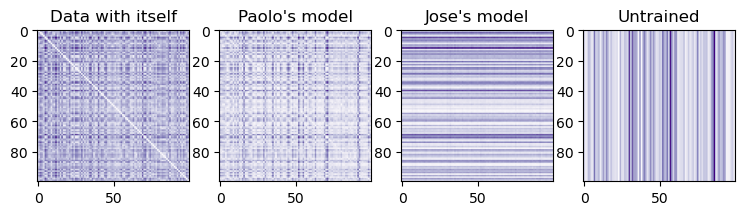

In [2]:
#### Calculating distances

print(val_data.shape)
print(val_data_net.shape)
print(val_data_paolo.shape)


f, ax = plt.subplots(1, 4, figsize=(9,3))

ax[0].imshow(scipy.spatial.distance.cdist(val_data, val_data),       cmap = 'Purples')
ax[0].set_title('Data with itself')

ax[1].imshow(scipy.spatial.distance.cdist(val_data, val_data_paolo), cmap = 'Purples')
ax[1].set_title('Paolo\'s model')

ax[2].imshow(scipy.spatial.distance.cdist(val_data, val_data_net),   cmap = 'Purples')
ax[2].set_title('Jose\'s model')

ax[3].imshow(scipy.spatial.distance.cdist(val_data, val_untrained),   cmap = 'Purples')
ax[3].set_title('Untrained')


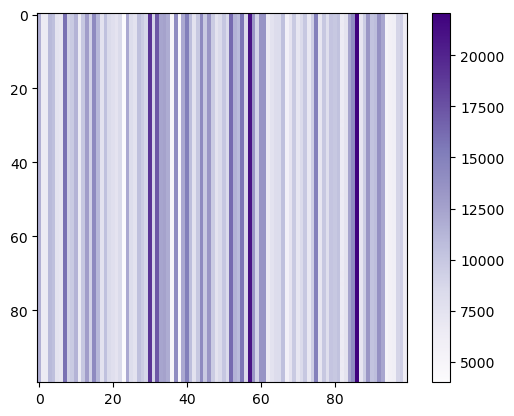

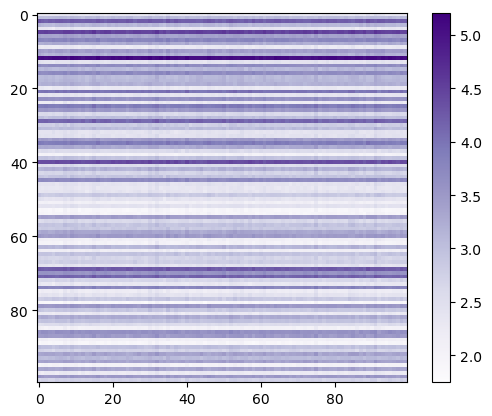

In [28]:
plt.imshow(scipy.spatial.distance.cdist(val_data, val_untrained),   cmap = 'Purples')
plt.colorbar()
plt.show()
plt.imshow(scipy.spatial.distance.cdist(val_data, val_data_net),   cmap = 'Purples')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
import numpy as np
import scipy
plt.hist(scipy.spatial.distance.cdist(val_data, val_data)[np.triu_indices(100, k=1)], bins =100)

In [7]:
print('Natural mean: ', np.mean(scipy.spatial.distance.cdist(val_data, val_data)[np.triu_indices(100, k=1)]))
print('My mean:      ', np.mean(np.diagonal(scipy.spatial.distance.cdist(val_data, val_data_net))))
print('Untrained:    ', np.mean(np.diagonal(scipy.spatial.distance.cdist(val_data, val_untrained))))
print('Paolo mean:   ', np.mean(np.diagonal(scipy.spatial.distance.cdist(val_data, val_data_paolo))))

Natural mean:  3.677585958205236
My mean:       2.9644446471986807
Untrained:     10121.446660415422
Paolo mean:    1.851574975329136


0.0


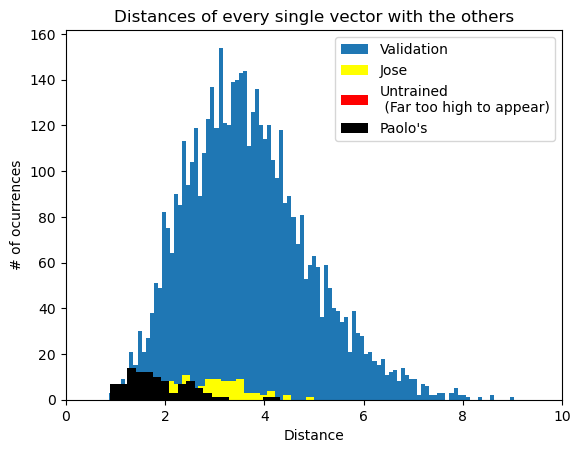

In [32]:
print(np.sum(np.abs(np.diagonal(scipy.spatial.distance.cdist(val_data, val_data)))))  # Sanity check)

plt.hist(scipy.spatial.distance.cdist(val_data, val_data)[np.triu_indices(100, k=1)], bins =100, label = 'Validation')
plt.hist(np.diagonal(scipy.spatial.distance.cdist(val_data, val_data_net)), bins=20,   color='yellow', label='Jose')
plt.hist(np.diagonal(scipy.spatial.distance.cdist(val_data, val_untrained)), bins=20,   color='r', label='Untrained\n (Far too high to appear)')
plt.hist(np.diagonal(scipy.spatial.distance.cdist(val_data, val_data_paolo)), bins=20, color='k', label='Paolo\'s')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('# of ocurrences')
plt.title('Distances of every single vector with the others')
plt.xlim(0, 10)
plt.savefig('Distances.png')

In [34]:
np.mean(np.diagonal(scipy.spatial.distance.cdist(val_data, val_data_net)))

2.9644446471986807

In [35]:
np.mean(np.diagonal(scipy.spatial.distance.cdist(val_data, val_data_paolo)))

1.851574975329136

In [33]:
print('Me\'s: ', np.round(torch.nn.functional.mse_loss(torch.tensor(val_data), torch.tensor(val_data_net)).item(),2))
print('Paolo\'s:  ',np.round(torch.nn.functional.mse_loss(torch.tensor(val_data), torch.tensor(val_data_paolo)).item(),2))

Me's:  0.89
Paolo's:   0.09


In [38]:
torch.sum(net.w)

tensor(27.2377, device='cuda:0', grad_fn=<SumBackward0>)

In [37]:
### How mse loss is working here
d_p, d_m=[], []
for i in range(100):
    A=val_data[i,:]
    B=val_data_net[i,:]
    C=val_data_paolo[i,:]
    d_m.append(((A-B)**2).mean(axis=0))
    d_p.append(((A-C)**2).mean(axis=0))
print(np.round(np.mean(d_m),2), np.round(np.mean(d_p),2))

0.21 0.09
